# **Конфигурация**

Здесь осуществялется **указание переменных проекта**, **подключение всех импортов**.

## Импорты

Здесь осуществляется импорт всех используемых в проекте библиотек. **Все импорты следует указывать здесь**.

In [56]:
import os, glob, random, shutil, ntpath, cv2, pandas as pd, tensorflow as tf
from pathlib import Path
from PIL import Image
from google.colab import drive
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

## Подключение данных

Здесь осуществляется подключение данных. Данными выступают фотографии. Фотографии берутся из Google Disk. Исходя из своих потребностей **вы можете сами определить для себя, откуда вы будете извлекать фотографии для формирования датасетов**. Это означает, что вам не обязательно выполнять данный блок, но придется переопределить его для своих нужд и возможностей, например, осуществляя локальную подгрузку файлов.

In [57]:
# подключение вашего гугл диска
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Функции

Здесь определяются функции, которые могут быть использованы во всех последующих блоках многократно.

In [58]:
# функция для подгрузки всех файлов
def get_files_from(path, exp):

  images = []

  for f in glob.glob("drive/MyDrive/csu/ML/" + path + "/" + "*." + exp):

    images.append(f)

  return images

# копирование файлов в указанную директорию
def copy_files_from(path, files):

  for f in files:

    shutil.copyfile(f, "drive/MyDrive/csu/ML/" + path + "/" + ntpath.basename(f))

# удаление всех файлов в директории
def remove_files_from(path):

  for f in glob.glob("drive/MyDrive/csu/ML/" + path + "/**/*", recursive = True):

    try:
      
      os.remove(f)
    
    except OSError as e:

      print(e)

## Переменные

Здесь определяются переменные проекта, которые будут использоваться во всех последующих блоках.

In [59]:
# кол-во эпох
epochs = 100
# ширина изображений
img_width = 224
# высота изображений
img_height = 224
# кол-во изображений
img_count = 640
# размеры изображения
img_size = (img_width, img_height, 3)
# размер пакета
batch_size = 32
# кол-во классов
num_classes = 2
# названия классов
class_names = ["Olds", "Youngs"]
# цвет
color_mode = "rgb"
# шаг валидации
validation_steps = 30
# основная директория
dir_main = Path("drive/MyDrive/csu/ML")
# пути к фотографиям старцев
class1 = get_files_from("Olds", "jpg")
# пути к фотографиям юнцов
class2 = get_files_from("Youngs", "jpg")
# массив всех изображений
images = class1 + class2
# агументация
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ],
    name='augmentation'
)
# входной поток
inputs = keras.Input(shape=img_size)
# цепочка выполнений
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
# выходной поток
outputs = layers.Dense(1, activation='sigmoid')(x)

# **Обработка данных**

Здесь осуществляется обработка данных, перед формированием наборов данных. Их можно искажать, подгонять под правильные размеры.

## Изменение размеров изображений

Здесь осуществялется изменение размеров всех фотографий.

In [5]:
for f in images:
  
  Image.open(f).resize((img_width, img_height)).save(f)

# **Формирование данных**

Здесь осуществялется формирование наборов данных.

## Очистка предыдущих наборов данных

Здесь осуществялется очистка всех фотографий из папок преназначенных для формирования наборов данных.

In [6]:
# удаление тренировочной папки
remove_files_from("Train/Olds")
remove_files_from("Train/Youngs")
# удаление валидационной папки
remove_files_from("Validate/Olds")
remove_files_from("Validate/Youngs")
# удаление тестовой папки
remove_files_from("Test/Olds")
remove_files_from("Test/Youngs")

## Заполнение папок наборов данных

Здесь формируются папки будущих наборов данных.

In [7]:
# заполнение тренировочной папки
copy_files_from("Train/Olds", class1[:(int)(len(class1)*0.7)])
copy_files_from("Train/Youngs", class2[:(int)(len(class2)*0.7)])

In [8]:
# заполнение валидационной папки
copy_files_from("Validate/Olds", class1[(int)(len(class1)*0.7):(int)(len(class1)*0.85)])
copy_files_from("Validate/Youngs", class2[(int)(len(class2)*0.7):(int)(len(class2)*0.85)])

In [9]:
# заполнение тестовой папки
copy_files_from("Test/Olds", class1[(int)(len(class1)*0.85):])
copy_files_from("Test/Youngs", class2[(int)(len(class2)*0.85):])

## Создание наборов данных

Здесь осуществляется формирование наборов данных, как объектов tf. Для формирования используется подгрузка данных из папок. **Формировать такие наборы следует в отдельных блоках**.

In [ ]:
# создание тренировочного датасета
train_ds = tf.keras.utils.image_dataset_from_directory(
  "drive/MyDrive/csu/ML/Train/",
  seed=123,
  shuffle=True,
  subset="validation",
  color_mode=color_mode,
  class_names = class_names,
  batch_size=batch_size,
  image_size=img_size[:2],
  validation_split=0.2)

In [11]:
# создание валидационного датасета
validate_ds = tf.keras.utils.image_dataset_from_directory(
  "drive/MyDrive/csu/ML/Validate/",
  seed=123,
  shuffle=True,
  subset="validation",
  color_mode=color_mode,
  class_names = class_names,
  batch_size=batch_size,
  image_size=img_size[:2],
  validation_split=0.2)

Found 94 files belonging to 2 classes.
Using 18 files for validation.


## Создание таблиц

Здесь осущетсвялется формирование таблиц на основе наборов данных.

In [ ]:
# тренировочный датафрейм
set_training = [(file.as_posix(), file.parent.name) for file in dir_main.joinpath("Train").glob("**/*.*")]
train_df = pd.DataFrame(data=set_training, columns=['file', 'label'])
train_df['label_i'] = train_df['label'].astype('category').cat.codes
train_df.head()

In [ ]:
# валидационный датафрейм
set_validate = [(file.as_posix(), file.parent.name) for file in dir_main.joinpath('Validate').glob('**/*.*')]
val_df = pd.DataFrame(data=set_validate, columns=['file', 'label'])
val_df['label_i'] = val_df['label'].astype('category').cat.codes
val_df.head()

# **Формирование Модели**

Здесь осуществляется формирование модели.

## Создание модели данных

In [60]:
# создание модели на основе наборов данных
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                           

## Компиляция

In [61]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# **Обучение Модели**

In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validate_ds)

Epoch 1/100
3/3 [==============================] - 70s 32s/step - loss: 2.4193 - accuracy: 0.5114 - val_loss: 0.7658 - val_accuracy: 0.2778
Epoch 2/100
1/3 [=========>....................] - ETA: 8s - loss: 0.7125 - accuracy: 0.4688

# Графики

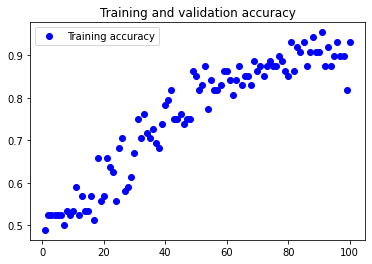

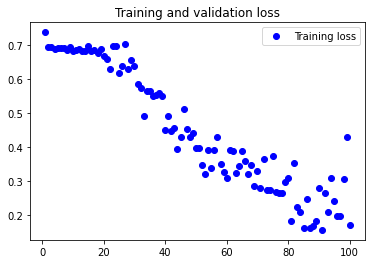

In [47]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.legend()
plt.title("Training and validation accuracy")
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()